# Adding Custom Operator Steps in Integration Schemes

In addition to forces that modify particle accelerations every timestep, we can use REBOUNDx to add operations that happen before and/or after each REBOUND timestep. rebx.add_operator will make reasonable default choices depending on the type of operator you are attaching to a simulation, but you can also manually specify exactly what you'd like to do. We show this here by generating custom splitting integration schemes, which are a powerful integration method for long-term dynamics (particularly symplectic ones). See Tamayo et al. 2019 for details and examples.

We begin by making a two-planet system:

In [1]:
import rebound
import reboundx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def makesim():
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=1.)
    sim.add(m=1.e-4, a=1.)
    sim.add(m=1.e-4, a=1.5)
    sim.move_to_com()
    return sim

We now consider a first-order Kepler splitting (Wisdom-Holman map):

$K(1)I(1)$

i.e., kick particles according to their interparticle forces for a full timestep (I), then evolve particles along a Kepler orbit (K) for a full timestep. 

We can build it up from kepler and interaction steps, so we begin by creating those

In [2]:
sim = makesim()
rebx = reboundx.Extras(sim)
kep = rebx.load_operator("kepler")
inter = rebx.load_operator("interaction")

We now set `sim.integrator` to none, so that REBOUND doesn't do anything in addition to the operators that we include, and we add our two operators, specifying the fraction of sim.dt we want each operator to act over (here the full timestep of 1). In this case since we've turned off the REBOUND timestep altogether, it doesn't matter if we add the operator "pre" timestep or "post" timestep, so we could have left it out.

Note that adding operators pushes them onto a linked list, so they will get executed in the opposite order that you add them in. Here, like we wrote above, the interaction step would happen first, followed by the Kepler step:

In [3]:
sim.integrator="none"
rebx.add_operator(kep, dtfraction=1., timing="pre")
rebx.add_operator(inter, dtfraction=1., timing="pre")

One can show (see Tamayo et al. 2019) that to leading order this scheme is equivalent to one where one integrates the motion exactly with IAS15, but one includes a half step backward in time before the IAS step, and a half step forward in time after, i.e.

$K(\frac{1}{2})IAS(1)K(-\frac{1}{2})$

In [4]:
sim2 = makesim()
rebx2 = reboundx.Extras(sim2)
kep = rebx2.load_operator("kepler")
ias = rebx2.load_operator("ias15")

sim2.integrator="none"
rebx2.add_operator(kep, dtfraction=0.5, timing="pre")
rebx2.add_operator(ias, dtfraction=1, timing="pre")
rebx2.add_operator(kep, dtfraction=-0.5, timing="pre")

We now integrate the orbits, track the energy errors and plot them:

In [5]:
dt = 0.0037*sim.particles[1].P
sim.dt = dt
sim2.dt = dt
Nout = 1000

E0 = sim.calculate_energy()
Eerr = np.zeros(Nout)
Eerr2 = np.zeros(Nout)
times = np.linspace(0, 10, Nout)

for i, time in enumerate(times):
    sim.integrate(time, exact_finish_time=0)
    sim2.integrate(time, exact_finish_time=0)
    E = sim.calculate_energy()
    E2 = sim2.calculate_energy()
    Eerr[i] = np.abs((E-E0)/E0)
    Eerr2[i] = np.abs((E2-E0)/E0)

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


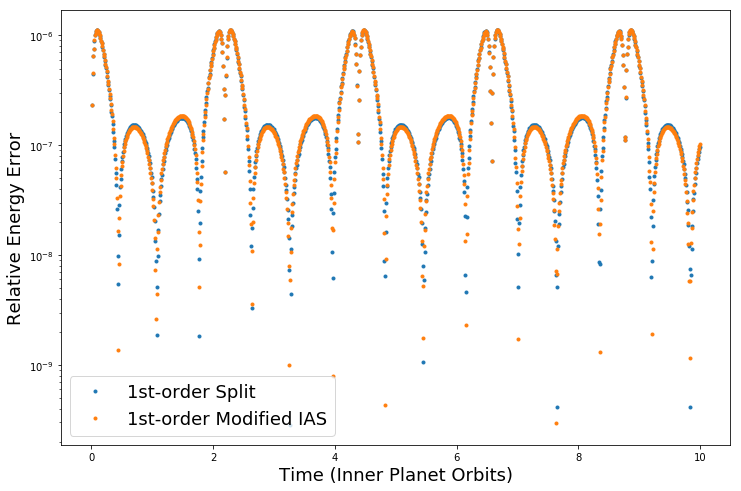

In [6]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, Eerr, '.', label='1st-order Split')
ax.plot(times, Eerr2, '.', label='1st-order Modified IAS')
ax.set_yscale('log')
ax.set_xlabel('Time (Inner Planet Orbits)', fontsize=18)
ax.set_ylabel('Relative Energy Error', fontsize=18)
ax.legend(fontsize=18)

This provides a straightforward and customizable way to experiment with higher order splitting schemes